# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using the following Baseline Method:
## Dropout as a Bayesian Approximation
https://arxiv.org/abs/1506.02142

Data Visualizations are contained in the notebook `Zurich Land Cover Density Forest.ipynb`

## 1. Import Libraries

In [1]:
%matplotlib inline
from multiprocessing import cpu_count
import sys
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# Meta-Parameters
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package Tree package

# custom libraries
from baselines.helpers import *
from baselines.plots import *
from helpers.plots import *
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *
from keras_helpers.MLP import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7906632305124207025
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10974989517
locality {
  bus_id: 1
}
incarnation: 17597492018774381622
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [2]:
class_to_remove = 2

## 2. Load Images

In [3]:
path = os.getcwd()

imgs, gt = load_data(path)

# gt to labels
# Next, we need to convert the ground truth (colors) to labels 
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

gt = gt_color_to_label(gt, colors)

images: 20 
ground truth images: 20 


### 2.2. Get patches

In [4]:
# Get patches
patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)
print(y_test_nostride.shape)

(3902, 64, 64, 4)
(964, 64, 64, 4)
(964, 64, 64)


## 3. Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [5]:
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [6]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [7]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Roads', 'Trees', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


### 3.1. Train CNN

In [8]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

<Figure size 432x288 with 0 Axes>

In [9]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [10]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### 3.2. Prediction on Test Set

In [11]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# Get accuracy as margin between highest and second highest class
y_pred_acc = get_acc_net_max_margin(y_pred)

3902/3902 [==============================] - 4s 1ms/step


In [12]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[...,np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

### 3.3. Accuracy Metrics (Test Set)

In [13]:
# Accuracy metrics
y_pred_flattened= np.asarray(y_pred_label.flatten()).astype('int')
y_test_flattened= np.asarray(y_test_nostride.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

         Roads      0.776     0.964     0.860    520742
         Trees      0.794     0.832     0.812    545015
         Grass      0.948     0.725     0.822    612397
     Bare Soil      0.627     0.750     0.683     66093
         Water      0.913     0.530     0.670     18705
      Railways      0.002     0.002     0.002     18526
Swimming Pools      0.000     0.000     0.000     10386

   avg / total      0.824     0.814     0.810   1791864

Overall accuracy: 81.413 %


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
# print to log file
import pandas as pd
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test_flattened[filter_items], y_pred_flattened[filter_items])
df = pd.DataFrame(data={'Precision':precision,
                        'Recall':recall,
                       'f1-score':fscore,
                       'support':support}, index=names_keep)

df.index.name = 'Class'
with open("models_out/acc_class_" + str(class_to_remove) + ".csv", 'w') as f:
    print(df.to_latex(float_format='%.3f'), file=f)  # Python 3.x

/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### CNN accuracies
```python
AA_CNN=[87.098, 81.905, 87.839, 81.076,
        81.236, 83.891, 81.091, 81.451] 
```

## Dropout as a Bayesian Approximation
https://arxiv.org/abs/1506.02142

In [15]:
# get predictions
y_preds = predict_with_dropout_imgs(model_unet, x_test,
                                    imgs, ids_test, batch_size=100,
                                    n_iter=100)

100%|██████████| 100/100 [06:15<00:00,  3.76s/it]


In [23]:
prediction = np.mean(y_preds, axis=-1)
uncertainty = np.mean(np.var(y_preds, -1),0)

In [22]:
np.shape(np.var(y_preds,-1))

(100, 964, 64, 64)

### Recall-Precision Curve

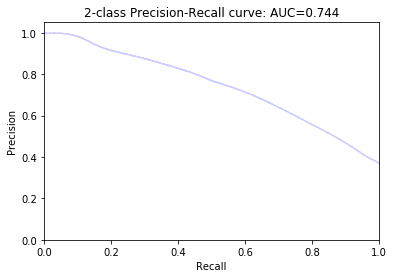

In [24]:
# Dropout
y_scores = uncertainty
y_true = ((y_pred_label==y_test_nostride)*1)

precision, recall, thresholds = metrics.precision_recall_curve(y_true.flatten(), y_scores.flatten())
plot_precision_recall(precision, recall, s_name="../Figures/DF/AUC/AUC_pred_wo_cl_" + str(class_to_remove) + "_Dropout.pdf")

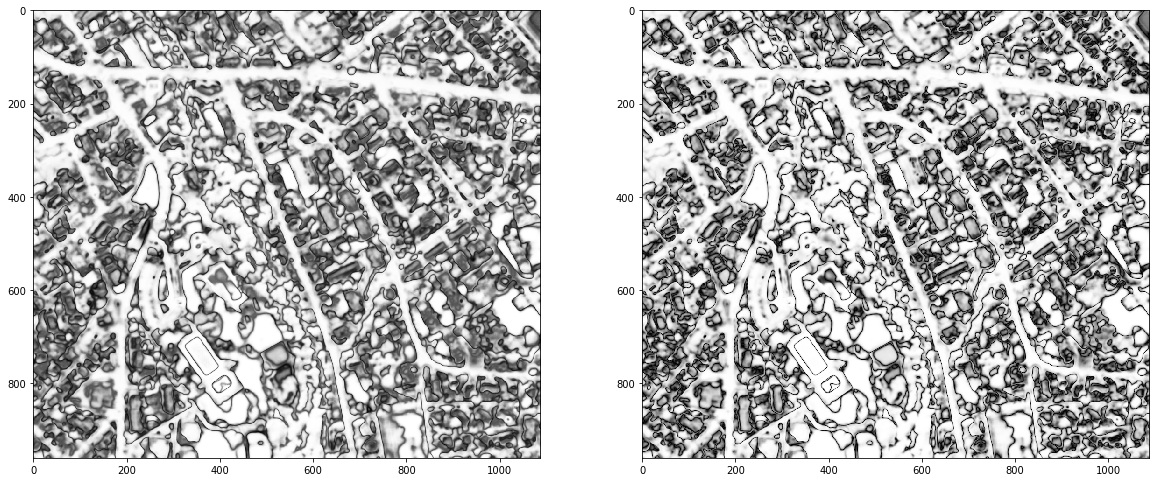

In [25]:
acc_dropout = convert_patches_to_image(imgs, y_scores[...,np.newaxis],16,64, 64,16)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(acc_dropout[...,0], cmap='gray')
axes[1].imshow(y_pred_acc_imgs[0][...,0], cmap='gray')